# Abalone

### Data:
* X_train (3341, 8)
* Y_train (3341,)

* X_test (836, 8)
* Y_test (836,)

### Source:
* https://archive.ics.uci.edu/ml/datasets/abalone

In [5]:
import math
import numpy as np

import tensorflow as tf
from tensorflow.python.framework import ops
import shutil
import pandas as pd
from tensorflow import keras

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Loading the data

In [6]:
## https://archive.ics.uci.edu/ml/datasets/abalone
data = pd.read_csv('abalone_data.txt', header = None, names = ["Sex","Length", "Diameter", "Height", "WholeWeight","ShuckedWeight","VisceraWeight","ShellWeight","Rings"])

In [7]:
print(data['Sex'].value_counts())

M    1528
I    1342
F    1307
Name: Sex, dtype: int64


### Data Preprocessing

In [8]:
# converting to labels
cleanup_nums = {"Sex":     {"M": 1, "I": 2, "F": 3}}
data.replace(cleanup_nums, inplace=True)

X = data.iloc[:,0:8]
Y = data.iloc[:,8]

# splitting data into train and test sets
X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

column_names = ["Sex","Length", "Diameter", "Height", "WholeWeight","ShuckedWeight","VisceraWeight","ShellWeight"]

# normalize
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [13]:
print("Training data shape:")
print("Input: {}".format(X_train.shape))
print("Output: {}".format(Y_train.shape))
print("Test data shape :")
print("Input: {}".format(X_test.shape))
print("Output: {}".format(y_test.shape))

Training data shape:
Input: (3341, 8)
Output: (3341,)
Test data shape :
Input: (836, 8)
Output: (836,)


### Model

In [14]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(X_train.shape[1],)),  ## 13 here
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


In [15]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [16]:
EPOCHS = 500

In [17]:
history = model.fit(X_train, Y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

#### Results

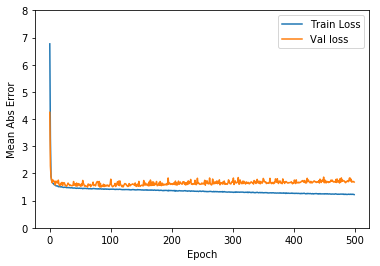

In [18]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 8])

plot_history(history)

### Add early stop callback to the model

In [19]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, Y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])


.................................................................................

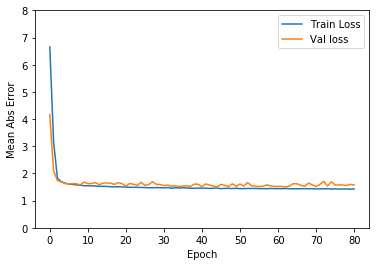

In [20]:
plot_history(history)

### Evaluate the model on test set

In [21]:
[loss, mae] = model.evaluate(X_test, y_test, verbose=0)

print("Testing set Mean Abs Error: {:7.2f}".format(mae))

Testing set Mean Abs Error:    1.51


In [22]:
test_predictions = model.predict(X_test).flatten()

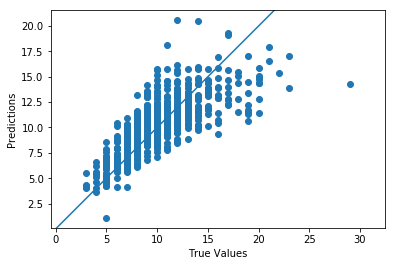

In [23]:
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

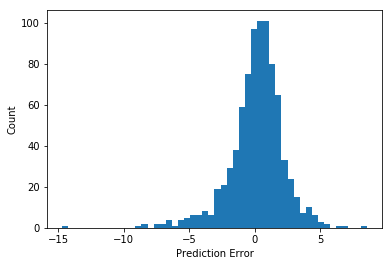

In [24]:
error = test_predictions - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")